# Training CNN with Chemical Images and 5-fold cross validation

### Full single-class dataset with 6,955 molecules in the 12-class set
### Uses validation set index 4 for the confusion matricies and ROC plots in the paper

## requires fastai version 0.7

#### Install instructions here: https://forums.fast.ai/t/fastai-v0-7-install-issues-thread/24652

In [20]:
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from random import sample
from itertools import chain
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, matthews_corrcoef 
from sklearn.metrics import balanced_accuracy_score, accuracy_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, MultiLabelBinarizer, label_binarize
from sklearn.model_selection import StratifiedKFold
import shutil

#### set some variables and set your GPU if you have multiple

In [21]:
torch.cuda.set_device(0)   ### use first GPU if you have many
PATH = "data/data_rmsalt_rmol2/pics/"  ### path to where your pictures are downloaded and the .csv files with val sets
sz = 150  ### resize images to this px by px
arch = resnext101_64  ### pre-trained network choice
bs = 25  ### batch size for minibatches


## functions


In [14]:
def get_val_idx_fromfile(validx_csv):
    validx_df =pd.read_csv(validx_csv, header=None)
    return validx_df[0].tolist()
    
def get_data(sz, bs, val_idxs, label_csv): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv,
                                       val_idxs=val_idxs, suffix='.png', tfms=tfms, bs=bs, num_workers=1)
    return data if sz > 300 else data.resize(340, 'tmp')

### Function to compute multiclass ROC AUC score from model predictions
def multiclass_roc_auc_score(y_test, y_probs, AVERAGE="weighted"):
    oh = OneHotEncoder(sparse=False, categories='auto')
    yt = oh.fit_transform(y_test.reshape(-1,1))
    return roc_auc_score(yt, y_probs, average=AVERAGE)

### 3-class, 5-fold cross validation, all single-class molecules in MeSH classes

In [22]:
### build nested cv loop
n_classes = 3
label_csv = f'{PATH}3cls_rmsaltol.csv'
valididx_base = '3cls_newskf'
reps=5   ### change to 5 for 5-fold cross validation
start=0  #### change to 0 to start at first set for 5-fold cross validation
# values to record per 
acc =[]
roc = []
mcc = []
bac = []
avp = []
for rep in range(reps):
    print(rep+start)
    shutil.rmtree(f'{PATH}tmp',ignore_errors=True) # delete the tmp folder every cycle to ensure no weird behavior
    val_idxs = get_val_idx_fromfile(f'{PATH}'+valididx_base+str(rep+start)+'.csv')
    data = get_data(sz, 25, val_idxs, label_csv)
    learn = ConvLearner.pretrained(arch, data, precompute=False, ps= 0.4)
    #learn.fit(5e-3, 3, cycle_len=1, cycle_mult=2)
    learn.unfreeze()
    #val_loss, val_acc = learn.fit(, params[1], cycle_len=1, cycle_mult=2)
    val_loss, val_acc = learn.fit([1e-4,1e-3,1e-2], 7, cycle_len=1, cycle_mult=2)
    ## record accuracy
    log_preds, y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)
    preds = np.argmax(probs, axis=1)
    acc.append(accuracy_score(y, preds))
    #acc.append(val_acc)
    # ROC weighted
    if(rep <6):
        roc.append(multiclass_roc_auc_score(y, probs, "weighted"))
        Y = label_binarize(y, classes = [x for x in range(0,n_classes)]) 
        avp.append(average_precision_score(Y, probs, average="weighted"))# ave PR
    # balanced accuracy
    bac.append(balanced_accuracy_score(y, preds))
    # MCC
    mcc.append(matthews_corrcoef(y, preds))
#record the mean 
print("accuracy")
print(round(np.mean(acc), ndigits =4))
print(round(np.std(acc), ndigits =4))
print('ROC AUC')
print(round(np.mean(roc), ndigits =4))
print(round(np.std(roc), ndigits =4))
print('Balanced Accuracy')
print(round(np.mean(bac), ndigits =4))
print(round(np.std(bac), ndigits =4))
print('MCC')
print(round(np.mean(mcc), ndigits =4))
print(round(np.std(mcc), ndigits =4))
print('av. precision recall')
print(round(np.mean(avp), ndigits =4))
print(round(np.std(avp), ndigits =4))


0


epoch      trn_loss   val_loss   accuracy                   
    0      1.073603   0.925816   0.590032  
    1      1.002985   0.904098   0.590032                   
    2      0.856832   0.756694   0.651125                    
    3      0.907684   0.859164   0.599678                    
    4      0.790378   0.701939   0.709003                   
    5      0.691185   0.640359   0.715434                    
    6      0.616978   0.627796   0.737942                    
    7      0.766557   0.717374   0.694534                    
    8      0.700388   0.718079   0.715434                   
    9      0.617688   0.690123   0.765273                    
    10     0.545745   0.603222   0.773312                    
    11     0.492898   0.569721   0.786174                    
    12     0.445649   0.591849   0.778135                    
    13     0.404508   0.538967   0.810289                    
    14     0.386012   0.536291   0.805466                    
    15     0.533028   0.570814

epoch      trn_loss   val_loss   accuracy                   
    0      1.065973   0.909498   0.585209  
    1      1.006962   0.985181   0.59164                    
    2      0.866949   0.885263   0.61254                     
    3      0.884523   0.985722   0.602894                    
    4      0.798417   0.803275   0.651125                    
    5      0.729989   0.718084   0.699357                   
    6      0.636532   0.701782   0.702572                    
    7      0.72051    0.834065   0.675241                    
    8      0.714907   0.715934   0.692926                    
    9      0.627922   0.699888   0.723473                    
    10     0.561749   0.663891   0.750804                    
    11     0.479007   0.552263   0.792605                    
    12     0.419814   0.565402   0.789389                   
    13     0.381586   0.533738   0.786174                    
    14     0.369948   0.532611   0.797428                   
    15     0.4841     0.640396 

epoch      trn_loss   val_loss   accuracy                   
    0      1.060885   0.898541   0.574879  
    1      0.986362   0.821595   0.637681                    
    2      0.851033   0.750224   0.674718                    
    3      0.894407   0.940156   0.613527                    
    4      0.803382   0.690391   0.713366                    
    5      0.672333   0.654944   0.752013                    
    6      0.608196   0.645469   0.745572                    
    7      0.699232   0.729428   0.710145                    
    8      0.669214   0.761715   0.714976                    
    9      0.586289   0.572494   0.784219                    
    10     0.561314   0.586793   0.772947                    
    11     0.449232   0.513895   0.813205                    
    12     0.413679   0.529527   0.814815                    
    13     0.398336   0.520395   0.816425                    
    14     0.385405   0.514085   0.816425                    
    15     0.474805   0.587

epoch      trn_loss   val_loss   accuracy                   
    0      1.06639    0.964355   0.545161  
    1      1.002937   0.937432   0.585484                   
    2      0.886297   0.802069   0.651613                    
    3      0.88709    0.853863   0.625806                    
    4      0.830674   0.783672   0.666129                    
    5      0.730135   0.697395   0.724194                   
    6      0.668637   0.678178   0.719355                    
    7      0.738916   0.697521   0.708065                    
    8      0.729045   0.696421   0.720968                    
    9      0.647304   0.64395    0.759677                    
    10     0.567333   0.601925   0.759677                    
    11     0.496229   0.56429    0.779032                    
    12     0.440629   0.555816   0.785484                    
    13     0.403546   0.551195   0.785484                    
    14     0.398224   0.549767   0.795161                    
    15     0.516847   0.64555

epoch      trn_loss   val_loss   accuracy                  
    0      1.095186   0.966414   0.567044  
    1      1.015646   0.904754   0.607431                   
    2      0.859017   0.832325   0.642973                    
    3      0.90395    0.756086   0.659128                    
    4      0.810609   0.739331   0.6979                      
    5      0.686546   0.678047   0.710824                    
    6      0.614083   0.656996   0.725363                    
    7      0.697924   0.821223   0.68336                     
    8      0.667837   0.717072   0.718901                    
    9      0.604026   0.654075   0.739903                    
    10     0.551596   0.630238   0.733441                    
    11     0.485625   0.57986    0.773829                    
    12     0.425827   0.547618   0.788368                    
    13     0.385647   0.538178   0.791599                    
    14     0.373675   0.533229   0.789984                    
    15     0.503859   0.62685

[[0.89 0.05 0.06]                            
 [0.08 0.78 0.13]
 [0.06 0.04 0.9 ]]


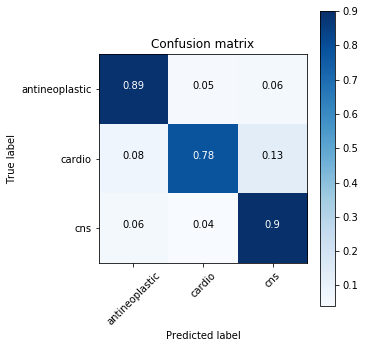

In [23]:
### plot confusion matrix showing per-class predictions
plt.rcParams['figure.figsize'] = [5, 5] ### size of the picture
log_preds, y = learn.TTA()  ### perform predictions and save the output
probs = np.mean(np.exp(log_preds), 0)
preds = np.argmax(probs, axis=1)
cm = confusion_matrix(y, preds)
adj = cm.transpose()/cm.sum(axis=1)
adj = adj.round(2)
plot_confusion_matrix(adj.transpose(), data.classes)
plt.savefig("3cls_aliper_CM.svg",type="svg")

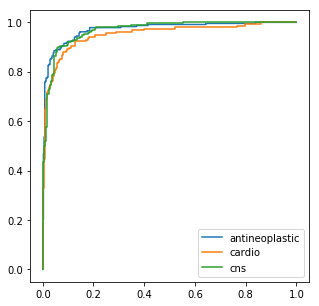

In [24]:
### plot ROC curves
for x in range(0,3):
    fpr, tpr, thresholds = roc_curve(y, probs[:,x], pos_label=x)
    plt.plot(fpr, tpr, label = data.classes[x])
plt.legend()
plt.savefig("3cls_aliper_ROC.svg",type="svg")

In [25]:
### build nested cv loop
n_classes = 5
label_csv = f'{PATH}5cls_rmsaltol.csv'
valididx_base = '5cls_newskf'
reps=5   ### change to 5 for 5-fold cross validation
start=0  #### change to 0 to start at first set for 5-fold cross validation
# values to record per 
acc =[]
roc = []
mcc = []
bac = []
avp = []
for rep in range(reps):
    print(rep+start)
    shutil.rmtree(f'{PATH}tmp',ignore_errors=True) # delete the tmp folder every cycle to ensure no weird behavior
    val_idxs = get_val_idx_fromfile(f'{PATH}'+valididx_base+str(rep+start)+'.csv')
    data = get_data(sz, 25, val_idxs, label_csv)
    learn = ConvLearner.pretrained(arch, data, precompute=False, ps= 0.4)
    #learn.fit(5e-3, 3, cycle_len=1, cycle_mult=2)
    learn.unfreeze()
    #val_loss, val_acc = learn.fit(, params[1], cycle_len=1, cycle_mult=2)
    val_loss, val_acc = learn.fit([1e-4,1e-3,1e-2], 7, cycle_len=1, cycle_mult=2)
    ## record accuracy
    log_preds, y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)
    preds = np.argmax(probs, axis=1)
    acc.append(accuracy_score(y, preds))
    #acc.append(val_acc)
    # ROC weighted
    if(rep <6):
        roc.append(multiclass_roc_auc_score(y, probs, "weighted"))
        Y = label_binarize(y, classes = [x for x in range(0,n_classes)]) 
        avp.append(average_precision_score(Y, probs, average="weighted"))# ave PR
    # balanced accuracy
    bac.append(balanced_accuracy_score(y, preds))
    # MCC
    mcc.append(matthews_corrcoef(y, preds))
#record the mean 
print("accuracy")
print(round(np.mean(acc), ndigits =4))
print(round(np.std(acc), ndigits =4))
print('ROC AUC')
print(round(np.mean(roc), ndigits =4))
print(round(np.std(roc), ndigits =4))
print('Balanced Accuracy')
print(round(np.mean(bac), ndigits =4))
print(round(np.std(bac), ndigits =4))
print('MCC')
print(round(np.mean(mcc), ndigits =4))
print(round(np.std(mcc), ndigits =4))
print('av. precision recall')
print(round(np.mean(avp), ndigits =4))
print(round(np.std(avp), ndigits =4))


0


epoch      trn_loss   val_loss   accuracy                   
    0      1.282392   1.112259   0.560659  
    1      1.213664   1.010746   0.592721                   
    2      0.995942   0.911513   0.64818                     
    3      1.091379   0.926779   0.62825                    
    4      0.955116   0.848106   0.67331                     
    5      0.815768   0.763435   0.711438                    
    6      0.742559   0.749692   0.719237                    
    7      0.879064   0.86561    0.662912                    
    8      0.846525   0.873125   0.669844                    
    9      0.700282   0.738797   0.733969                    
    10     0.600508   0.647336   0.767764                    
    11     0.537785   0.647252   0.77643                     
    12     0.518101   0.636606   0.791161                    
    13     0.442242   0.63734    0.789428                    
    14     0.442483   0.639347   0.792028                    
    15     0.618035   0.74056

epoch      trn_loss   val_loss   accuracy                   
    0      1.268937   1.129661   0.539861  
    1      1.134604   1.077234   0.564991                   
    2      0.985563   0.944139   0.621317                    
    3      1.061593   0.990331   0.604853                   
    4      0.91388    0.839879   0.664645                    
    5      0.767592   0.77787    0.689775                    
    6      0.739611   0.766799   0.695841                    
    7      0.857194   0.841179   0.691508                    
    8      0.763676   0.781603   0.694974                    
    9      0.748791   0.744319   0.730503                    
    10     0.602464   0.686496   0.735702                    
    11     0.523484   0.691564   0.758232                    
    12     0.507548   0.6408     0.762565                    
    13     0.468252   0.621969   0.779896                    
    14     0.461106   0.622822   0.778163                    
    15     0.648152   0.75189

epoch      trn_loss   val_loss   accuracy                   
    0      1.264662   1.130433   0.555074  
    1      1.196166   0.967376   0.620989                   
    2      0.988021   0.896891   0.648742                    
    3      1.070603   0.919879   0.647008                   
    4      0.902524   0.807934   0.690373                    
    5      0.778344   0.763731   0.712923                    
    6      0.718646   0.750793   0.714657                    
    7      0.862016   0.844873   0.678231                    
    8      0.777681   0.782347   0.714657                    
    9      0.706313   0.738608   0.745013                    
    10     0.628155   0.666858   0.765828                    
    11     0.574535   0.676891   0.767563                    
    12     0.472082   0.606969   0.795317                    
    13     0.421025   0.610343   0.784909                    
    14     0.398576   0.603006   0.794449                    
    15     0.610368   0.74427

epoch      trn_loss   val_loss   accuracy                   
    0      1.268428   1.10782    0.561739  
    1      1.207636   1.026128   0.6                        
    2      1.008214   0.93167    0.64087                     
    3      1.067204   0.952577   0.63913                    
    4      0.929724   0.893907   0.662609                    
    5      0.786658   0.800987   0.714783                    
    6      0.712778   0.781852   0.715652                    
    7      0.893178   0.855914   0.674783                    
    8      0.794311   0.807226   0.706957                    
    9      0.71069    0.736749   0.733043                    
    10     0.655516   0.742628   0.726957                    
    11     0.571721   0.691681   0.762609                    
    12     0.484379   0.683493   0.77913                     
    13     0.446156   0.665499   0.784348                    
    14     0.41363    0.662882   0.782609                    
    15     0.624915   0.79248

epoch      trn_loss   val_loss   accuracy                   
    0      1.302295   1.104881   0.545692  
    1      1.13561    1.069207   0.560487                   
    2      1.00948    0.920937   0.630983                   
    3      1.04472    0.955321   0.624891                   
    4      0.956941   0.828061   0.672759                    
    5      0.814714   0.748441   0.718886                    
    6      0.732523   0.753483   0.719756                    
    7      0.89441    0.769745   0.699739                    
    8      0.794562   0.785089   0.70322                     
    9      0.698607   0.668901   0.749347                    
    10     0.601857   0.658855   0.765013                    
    11     0.557302   0.632183   0.770235                    
    12     0.487448   0.616627   0.785901                    
    13     0.427314   0.613225   0.792863                    
    14     0.41001    0.616646   0.793734                    
    15     0.61198    0.67981 

[[0.93 0.02 0.02 0.02 0.  ]                  
 [0.07 0.85 0.03 0.04 0.01]
 [0.1  0.01 0.76 0.13 0.  ]
 [0.07 0.02 0.04 0.85 0.02]
 [0.08 0.04 0.06 0.04 0.78]]


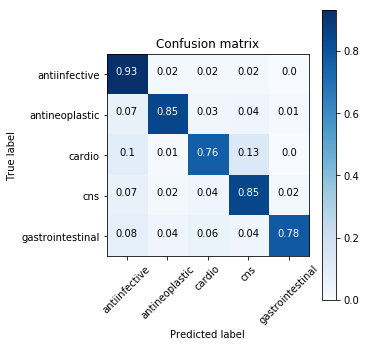

In [26]:
### plot confusion matrix showing per-class predictions
plt.rcParams['figure.figsize'] = [5, 5] ### size of the picture
log_preds, y = learn.TTA()  ### perform predictions and save the output
probs = np.mean(np.exp(log_preds), 0)
preds = np.argmax(probs, axis=1)
cm = confusion_matrix(y, preds)
adj = cm.transpose()/cm.sum(axis=1)
adj = adj.round(2)
plot_confusion_matrix(adj.transpose(), data.classes)
plt.savefig("5cls_aliper_CM.svg",type="svg")

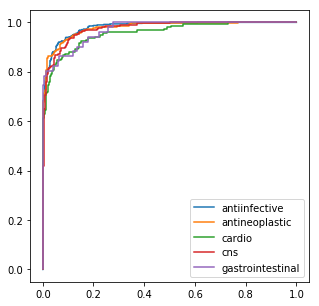

In [27]:
### plot ROC curves
for x in range(0,5):
    fpr, tpr, thresholds = roc_curve(y, probs[:,x], pos_label=x)
    plt.plot(fpr, tpr, label = data.classes[x])
plt.legend()
plt.savefig("5cls_aliper_ROC.svg",type="svg")

In [28]:
### build nested cv loop
n_classes = 12
label_csv = f'{PATH}12cls_rmsaltol.csv'
valididx_base = '12cls_newskf'
reps=5   ### change to 5 for 5-fold cross validation
start=0  #### change to 0 to start at first set for 5-fold cross validation
# values to record per 
acc =[]
roc = []
mcc = []
bac = []
avp = []
for rep in range(reps):
    print(rep+start)
    shutil.rmtree(f'{PATH}tmp',ignore_errors=True) # delete the tmp folder every cycle to ensure no weird behavior
    val_idxs = get_val_idx_fromfile(f'{PATH}'+valididx_base+str(rep+start)+'.csv')
    data = get_data(sz, 25, val_idxs, label_csv)
    learn = ConvLearner.pretrained(arch, data, precompute=False, ps= 0.4)
    #learn.fit(5e-3, 3, cycle_len=1, cycle_mult=2)
    learn.unfreeze()
    #val_loss, val_acc = learn.fit(, params[1], cycle_len=1, cycle_mult=2)
    val_loss, val_acc = learn.fit([1e-4,1e-3,1e-2], 7, cycle_len=1, cycle_mult=2)
    ## record accuracy
    log_preds, y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)
    preds = np.argmax(probs, axis=1)
    acc.append(accuracy_score(y, preds))
    #acc.append(val_acc)
    # ROC weighted
    if(rep <6):
        roc.append(multiclass_roc_auc_score(y, probs, "weighted"))
        Y = label_binarize(y, classes = [x for x in range(0,n_classes)]) 
        avp.append(average_precision_score(Y, probs, average="weighted"))# ave PR
    # balanced accuracy
    bac.append(balanced_accuracy_score(y, preds))
    # MCC
    mcc.append(matthews_corrcoef(y, preds))
#record the mean 
print("accuracy")
print(round(np.mean(acc), ndigits =4))
print(round(np.std(acc), ndigits =4))
print('ROC AUC')
print(round(np.mean(roc), ndigits =4))
print(round(np.std(roc), ndigits =4))
print('Balanced Accuracy')
print(round(np.mean(bac), ndigits =4))
print(round(np.std(bac), ndigits =4))
print('MCC')
print(round(np.mean(mcc), ndigits =4))
print(round(np.std(mcc), ndigits =4))
print('av. precision recall')
print(round(np.mean(avp), ndigits =4))
print(round(np.std(avp), ndigits =4))

0


epoch      trn_loss   val_loss   accuracy                   
    0      1.717571   1.516467   0.4932    
    1      1.548927   1.372379   0.546886                   
    2      1.405729   1.263202   0.58053                    
    3      1.392613   1.282716   0.566213                   
    4      1.271157   1.186816   0.613457                   
    5      1.096115   1.046458   0.664281                   
    6      1.048236   1.037855   0.67287                     
    7      1.154828   1.136398   0.618468                   
    8      1.082033   1.065903   0.655691                   
    9      0.97191    0.960113   0.686471                    
    10     0.839232   0.899309   0.717967                    
    11     0.746177   0.842106   0.743021                    
    12     0.645044   0.822831   0.745168                    
    13     0.586353   0.82393    0.754474                    
    14     0.550879   0.829351   0.750179                    
    15     0.854841   0.963813   0

epoch      trn_loss   val_loss   accuracy                   
    0      1.81088    1.597592   0.465567  
    1      1.636543   1.495334   0.482066                   
    2      1.348095   1.345343   0.539455                   
    3      1.35361    1.300361   0.553085                   
    4      1.250349   1.192161   0.612626                   
    5      1.096247   1.09441    0.64132                    
    6      0.96648    1.081801   0.637016                    
    7      1.152657   1.159773   0.626255                   
    8      1.062229   1.084915   0.649928                   
    9      0.937894   1.03962    0.677905                    
    10     0.868485   1.001644   0.697991                    
    11     0.719284   0.977264   0.712339                    
    12     0.628267   0.966238   0.71736                     
    13     0.572751   0.953889   0.725968                    
    14     0.534755   0.938689   0.727403                    
    15     0.803931   1.020716   0

epoch      trn_loss   val_loss   accuracy                   
    0      1.695318   1.543681   0.463362  
    1      1.588324   1.493084   0.481322                   
    2      1.381103   1.315543   0.550287                   
    3      1.477091   1.324545   0.548132                   
    4      1.266681   1.156756   0.624282                   
    5      1.102489   1.032035   0.665948                   
    6      1.006847   1.027699   0.679598                    
    7      1.196611   1.182269   0.604885                   
    8      1.105727   1.041637   0.668103                   
    9      0.9897     0.981076   0.693247                    
    10     0.867037   0.91828    0.717672                    
    11     0.777177   0.843551   0.751437                    
    12     0.662167   0.821659   0.756466                    
    13     0.607771   0.821271   0.765086                    
    14     0.592335   0.80872    0.767241                    
    15     0.875097   1.013333   0

epoch      trn_loss   val_loss   accuracy                   
    0      1.779293   1.527728   0.495314  
    1      1.5794     1.376378   0.511175                   
    2      1.393204   1.257848   0.561644                   
    3      1.423497   1.284601   0.570296                   
    4      1.287028   1.178584   0.630137                   
    5      1.129271   1.0596     0.667628                   
    6      1.024099   1.048804   0.670512                    
    7      1.186362   1.120421   0.628695                   
    8      1.048987   1.074312   0.668349                   
    9      1.001508   0.979789   0.686373                    
    10     0.909823   0.943811   0.702235                    
    11     0.728067   0.907815   0.732516                    
    12     0.670248   0.89443    0.736842                    
    13     0.637063   0.858962   0.743331                    
    14     0.579459   0.863241   0.741168                    
    15     0.906643   1.021284   0

epoch      trn_loss   val_loss   accuracy                   
    0      1.700138   1.570992   0.473646  
    1      1.591493   1.389755   0.513357                   
    2      1.423342   1.321131   0.548014                   
    3      1.407149   1.279909   0.570397                   
    4      1.258221   1.155423   0.607942                   
    5      1.070171   1.057433   0.651264                   
    6      0.99856    1.039548   0.656318                    
    7      1.198838   1.129736   0.618773                   
    8      1.059649   1.06553    0.65704                    
    9      0.940839   0.933255   0.696751                    
    10     0.836929   0.925715   0.711913                    
    11     0.689437   0.856588   0.716968                    
    12     0.603563   0.828393   0.737184                    
    13     0.565063   0.828151   0.73574                     
    14     0.540189   0.83182    0.741516                    
    15     0.831354   0.9431     0

[[0.92 0.01 0.02 0.02 0.02 0.   0.01 0.   0.   0.   0.   0.  ]
 [0.07 0.78 0.03 0.03 0.07 0.   0.   0.   0.01 0.   0.01 0.  ]
 [0.07 0.01 0.82 0.03 0.05 0.   0.   0.01 0.   0.   0.   0.  ]
 [0.06 0.01 0.03 0.73 0.1  0.01 0.01 0.01 0.01 0.01 0.02 0.  ]
 [0.06 0.01 0.02 0.03 0.85 0.   0.01 0.   0.   0.   0.01 0.  ]
 [0.17 0.09 0.   0.04 0.   0.52 0.09 0.   0.04 0.   0.   0.04]
 [0.06 0.   0.04 0.1  0.02 0.02 0.76 0.   0.   0.   0.   0.  ]
 [0.   0.06 0.06 0.11 0.06 0.   0.04 0.66 0.02 0.   0.   0.  ]
 [0.06 0.   0.09 0.09 0.   0.   0.   0.   0.75 0.   0.   0.  ]
 [0.   0.   0.   0.   0.1  0.   0.   0.   0.   0.9  0.   0.  ]
 [0.05 0.   0.05 0.3  0.   0.   0.   0.   0.   0.05 0.55 0.  ]
 [0.   0.   0.   0.2  0.4  0.   0.   0.   0.   0.   0.   0.4 ]]


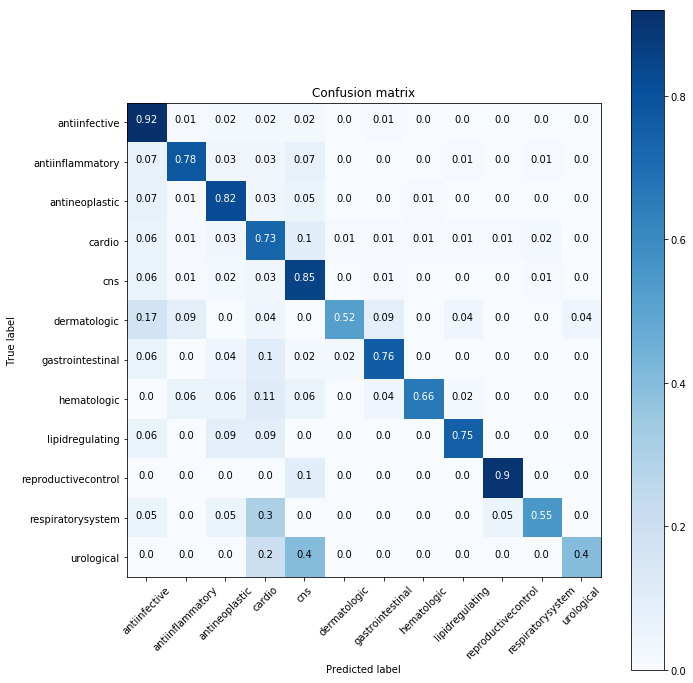

In [29]:
### plot confusion matrix showing per-class predictions
plt.rcParams['figure.figsize'] = [10, 10] ### size of the picture
log_preds, y = learn.TTA()  ### perform predictions and save the output
probs = np.mean(np.exp(log_preds), 0)
preds = np.argmax(probs, axis=1)
cm = confusion_matrix(y, preds)
adj = cm.transpose()/cm.sum(axis=1)
adj = adj.round(2)
plot_confusion_matrix(adj.transpose(), data.classes)
plt.savefig("12cls_aliper_CM.svg",type="svg")

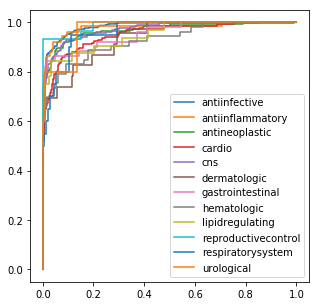

In [31]:
plt.rcParams['figure.figsize'] = [5, 5] ### size of the picture
### plot ROC curves
for x in range(0,12):
    fpr, tpr, thresholds = roc_curve(y, probs[:,x], pos_label=x)
    plt.plot(fpr, tpr, label = data.classes[x])
plt.legend()
plt.savefig("12cls_aliper_ROC.svg",type="svg")